In [ ]:

# https://seaborn.pydata.org/generated/seaborn.heatmap.html

In [ ]:

import sys

command_str = '{sys.executable} -m pip install --upgrade seaborn'.format(sys=sys)
print(command_str)
!{command_str}

In [1]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [ ]:

%run ../../load_magic/storage.py
%run ../../load_magic/paths.py
%run ../../load_magic/lists.py
%run ../../load_magic/environment.py
%run ../../load_magic/dataframes.py

import scraping_utils
wikipedia = scraping_utils.wikipedia

from IPython.display import clear_output
from bs4 import BeautifulSoup as bs
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import pearsonr
from tqdm import tqdm_notebook as tqdm
from urllib import request
from urllib.parse import unquote
import networkx as nx
import numpy as np
import re
import seaborn as sns; sns.set()
import wikidata

notebook_path = get_notebook_path()
print(notebook_path)
s = Storage()
counties_df = s.load_object('counties_df')
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])

%pprint
dir()


----


# 2 Explanation of different measures

[Picture would be nice]

**Example 2.1.** Consider three countries, each with 100,000 people and an area of $100km^2$, and think about the population of each square kilometre grid square.

1.  *Averagia*  has  a  uniform  spread  of  population,  with  1,000  people  living  in  each  gridsquare.
2.  *Builtupia*  has  ten  towns,  each  of  10,000  people  living  in  a  single  square  kilometre, and the remaining land is uninhabited.
3.  *Citia* has one city, where 100,000 people live in a single square kilometre, and where the remaining land is uninhabited.


Examples

Plot a heatmap for a numpy array:


## Heatmap on a 10x10 grid?

In [1]:

import numpy as np

total_pop = 100_000

# Averagia has a uniform spread of population, with 1,000 people living in each gridsquare.
averagia_people_count = 1_000
averagia_town_count = total_pop / averagia_people_count

# Builtupia has ten towns, each of 10,000 people living in a single square kilometre, and the remaining land is uninhabited.
builtupia_people_count = 10_000
builtupia_town_count = total_pop / builtupia_people_count

# Citia has one city, where 100,000 people live in a single square kilometre, and where the remaining land is uninhabited.
citia_people_count = 100_000
citia_town_count = total_pop / citia_people_count

gridsquare_count = total_pop / averagia_people_count
side_length = int(np.sqrt(gridsquare_count))

In [2]:

%run ../../load_magic/storage.py
s = Storage()
averagia_data = s.load_object('averagia_data')
averagia_annot_array = np.array(['{}K'.format(int(d/averagia_people_count)) for d in averagia_data.flat]).reshape(averagia_data.shape)
builtupia_data = s.load_object('builtupia_data')
builtupia_annot_array = np.array(['{}K'.format(int(d/averagia_people_count)) for d in builtupia_data.flat]).reshape(averagia_data.shape)
citia_data = s.load_object('citia_data')
citia_annot_array = np.array(['{}K'.format(int(d/averagia_people_count)) for d in citia_data.flat]).reshape(averagia_data.shape)

In [ ]:

averagia_data = np.rot90(s.load_object('averagia_data'))
averagia_annot_array = np.array(['{}K'.format(int(d/averagia_people_count)) for d in averagia_data.flat]).reshape(averagia_data.shape)
builtupia_data = np.rot90(s.load_object('builtupia_data'))
builtupia_annot_array = np.array(['{}K'.format(int(d/averagia_people_count)) for d in builtupia_data.flat]).reshape(averagia_data.shape)
citia_data = np.rot90(s.load_object('citia_data'))
citia_annot_array = np.array(['{}K'.format(int(d/averagia_people_count)) for d in citia_data.flat]).reshape(averagia_data.shape)

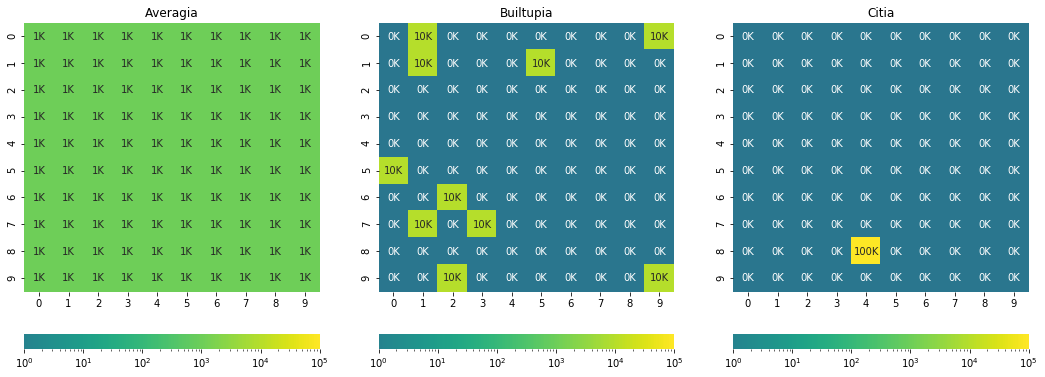

In [7]:

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.colors import LogNorm
import copy

# Create six axes and accesses them through the returned array
fig = plt.figure(figsize=(18, 18/3))
row_count = 2
column_count = 3
grid_kws = {'height_ratios': (.9, .05), 'hspace': .3}
axes = fig.subplots(row_count, column_count, gridspec_kw=grid_kws)
tuple_list = [(averagia_data, averagia_annot_array, 'Averagia'),
              (builtupia_data, builtupia_annot_array, 'Builtupia'),
              (citia_data, citia_annot_array, 'Citia')]
row = 0
cbar_kws = {'orientation': 'horizontal'}
cmap = copy.copy(mpl.cm.get_cmap('viridis'))
cmap.set_bad(cmap(100)[:-1])
norm = LogNorm(vmin=1, vmax=total_pop, clip=False)
lw = 0.0
for col, data_tuple in enumerate(tuple_list):
    data = data_tuple[0]
    annot_array = data_tuple[1]
    title = data_tuple[2]
    ax = axes[row, col]
    cbar_ax = axes[row+1, col]
    ax = sns.heatmap(data, vmin=1, vmax=citia_people_count, center=builtupia_people_count, annot=annot_array,
                     fmt='s', linewidths=lw, cmap=cmap, ax=ax, cbar_ax=cbar_ax, cbar_kws=cbar_kws, norm=norm)
    Text_tuple = ax.set_title(title)

In [7]:

import matplotlib

matplotlib.use('pgf')
matplotlib.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

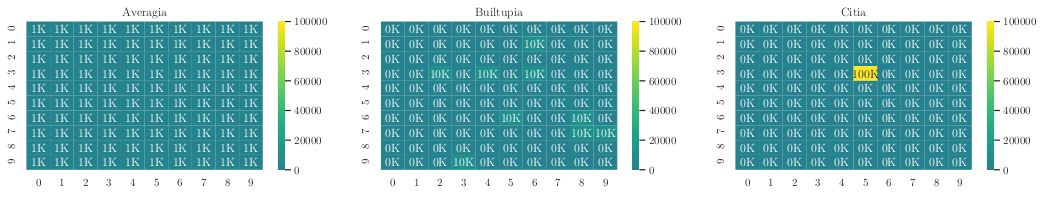

In [73]:

from matplotlib.ticker import FormatStrFormatter, FuncFormatter
from mpl_toolkits import mplot3d

# Setup the figure and axes
fig = plt.figure(figsize=(18, 18/3))
averagia_hm_ax = fig.add_subplot(231)
builtupia_hm_ax = fig.add_subplot(232)
citia_hm_ax = fig.add_subplot(233)

cmap = 'viridis'
ax = sns.heatmap(averagia_data, vmin=0, vmax=citia_people_count, center=builtupia_people_count, annot=averagia_annot_array,
                 fmt='s', linewidths=lw, cmap=cmap, ax=averagia_hm_ax)
Text_tuple = averagia_hm_ax.set_title('Averagia')
ax = sns.heatmap(builtupia_data, vmin=0, vmax=citia_people_count, center=builtupia_people_count, annot=builtupia_annot_array,
                 fmt='s', linewidths=lw, cmap=cmap, ax=builtupia_hm_ax)
Text_tuple = builtupia_hm_ax.set_title('Builtupia')
ax = sns.heatmap(citia_data, vmin=0, vmax=citia_people_count, center=builtupia_people_count, annot=citia_annot_array,
                 fmt='s', linewidths=lw, cmap=cmap, ax=citia_hm_ax)
Text_tuple = citia_hm_ax.set_title('Citia')
pgf_dir = os.path.join(s.saves_folder, 'pgf')
os.makedirs(name=pgf_dir, exist_ok=True)
fig.savefig(os.path.join(pgf_dir, 'example_2_1_heat_map.pgf'))

In [69]:

print(['ax.{}'.format(fn) for fn in dir(ax) if 'bar' in fn.lower()])
print(['fig.{}'.format(fn) for fn in dir(fig) if 'bar' in fn.lower()])
print(['plt.{}'.format(fn) for fn in dir(plt) if 'bar' in fn.lower()])

['ax.bar', 'ax.barbs', 'ax.barh', 'ax.broken_barh', 'ax.errorbar']
['fig.colorbar']
['plt.bar', 'plt.barbs', 'plt.barh', 'plt.broken_barh', 'plt.colorbar', 'plt.errorbar']



Change the limits of the colormap:

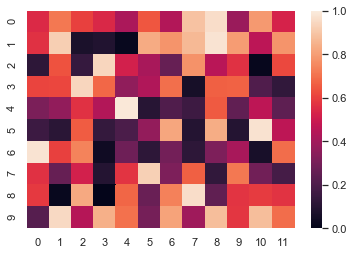

In [17]:

ax = sns.heatmap(uniform_data, vmin=0, vmax=1)


Plot a heatmap for data centered on 0 with a diverging colormap:

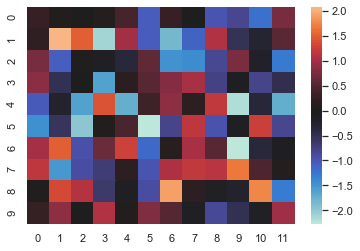

In [22]:

normal_data = np.random.randn(10, 12)
ax = sns.heatmap(normal_data, center=0)


Plot a dataframe with meaningful row and column labels:

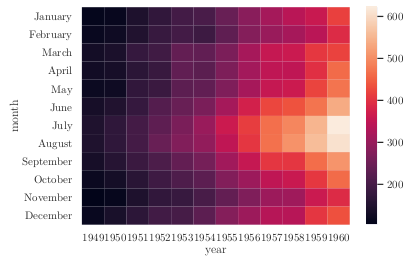

In [12]:

flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
ax = sns.heatmap(flights)


Annotate each cell with the numeric value using integer formatting:

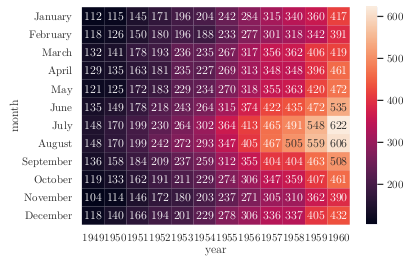

In [13]:

ax = sns.heatmap(flights, annot=True, fmt="d")


Add lines between each cell:

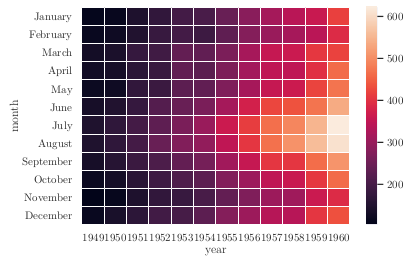

In [14]:

ax = sns.heatmap(flights, linewidths=.5)


Use a different colormap:

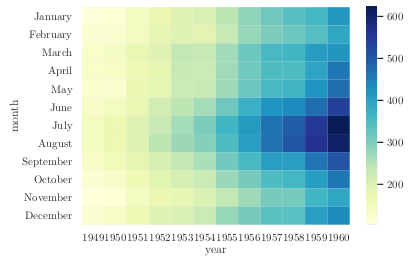

In [15]:

ax = sns.heatmap(flights, cmap='YlGnBu')


Center the colormap at a specific value:

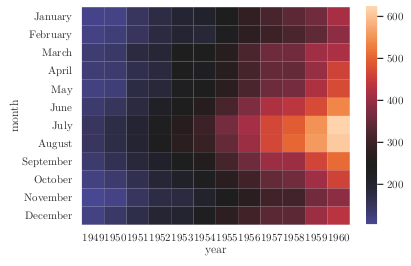

In [16]:

ax = sns.heatmap(flights, center=flights.loc["January", 1955])


Plot every other column label and don’t plot row labels:

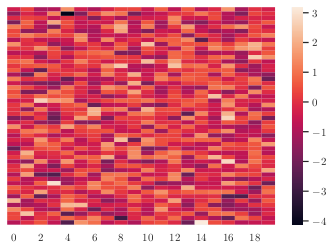

In [17]:

data = np.random.randn(50, 20)
ax = sns.heatmap(data, xticklabels=2, yticklabels=False)


Don’t draw a colorbar:

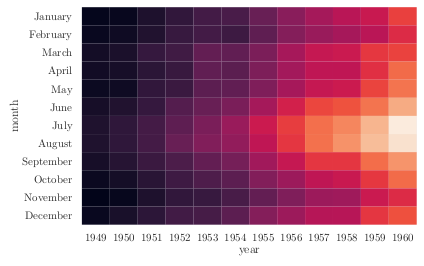

In [18]:

ax = sns.heatmap(flights, cbar=False)


Use different axes for the colorbar:

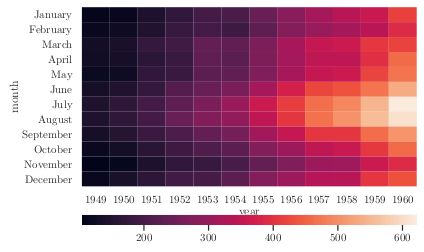

In [19]:

grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
ax = sns.heatmap(flights, ax=ax,
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal"})


Use a mask to plot only part of a matrix

In [ ]:

corr = np.corrcoef(np.random.randn(10, 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)


----

In [396]:

import pyperclip

pyperclip.copy(str(tuple((v, k) for k, v in idx_dict.items())))